In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

import warnings
warnings.filterwarnings('ignore')

# Fundamentos de desoxidación de aceros

**Dr. Edgar Ivan Castro Cedeño**

[edgar.castro@cinvestav.mx](mailto:edgar.castro@cinvestav.mx)

## Contexto metalúrgico

Al terminar el proceso de refinación primaria del acero (BOF/EAF), se tiene un acero que contiene grandes cantidades de oxígeno disuelto en el baño. El orden de magnitud es:

$$a_O > 300 \, ppm$$

Una de las étapas en la refinación secundaria del acero es la desoxidación del baño, que se puede realizar mediante la adición de un agente desoxidante o mediante un tratamiento de vacío.

Este documento se enfoca en presentar conceptos básicos de desoxidación mediante la adición de agentes desoxidantes, y la aplicación de los mismos en el proceso de refinación secundaria de aceros.

## Reacción general de desoxidación

De forma general, la reacción de desoxidación de un acero se puede expresar como:

$$\left(M_xO_y\right) = x\left[M\right] + y\left[O_x\right] $$

$$K = \frac{a_M^x a_O^y}{a_{M_xO_y}} $$

donde $a_{M_xO_y}$, $a_M^x$, y $a_O^y$, son las actividades termodinámicas de las especies químicas de interés.

### Estados de referencia

Para los **productos de desoxidación** se utiliza la substancia pura como estado de referencia:

$$a_{M_xO_y} = \gamma_{M_xO_y} {X_{M_xO_y}} $$
    
| Símbolo | Descripción |
| --- | --- |
|$a_{M_xO_y}$ | Actividad del producto de desoxidación $M_xO_y$  |   
|$\gamma_{M_xO_y}$ | Coeficiente de actividad Raoultiano  |
|$X_{M_xO_y}$ | Contenido de $M_xO_y$ en el producto de desoxidación, en fracción molar. |

En este documento no se habla de métodos para estimar la actividad de los productos de desoxidación en sistemas complejos.

Para los **solutos en el baño de metal fundido** se utiliza la solución Henriana con dilución al 1% en masa como estado de referencia:

$$h_M = f_M {\left[\%M\right]} $$

| Símbolo | Descripción |
| --- | --- |
|$h_M$ | actividad del soluto $M$ |
|$f_M$ | Coeficiente de actividad henriana |
|$\left[ \%M \right]$ | Contenido del soluto $M$ en el baño, in porcentaje másico.   |

### Formalismo de Wagner de coeficientes de interacción

Para considerar la dependencia entre la composición del baño y los coeficientes de actividad de los solutos, se va a utilizar el formalismo de Wagner.

$$\log f_i = \sum\limits_{j=2}^{n}{e_i^j \left[\%j\right]} 
        + \sum\limits_{j=2}^n{r_i^j \left[ \%j\right]^2} 
        + \sum\limits_{j=2}^{n-1} \sum\limits_{k>j}^{n} {r_i^{j,k} \left[\%j\right]\left[\%k\right]}$$
        
        
| Símbolo | Descripción |
| --- | --- |
|$e_i^j$     | Coeficiente de interacción de primer orden para el soluto $i$ en presencia del soluto $j$ |
|$r_i^j$     | Coeficiente de interacción de segundo orden para el soluto $i$ en presencia del soluto $j$ |
|$r_i^{j,k}$ | Coeficiente de interacción de segundo orden para el soluto $i$ en presencia de los soluto $j$, $k$ |

Aunque este formalismo fue definido originalmente para soluciones en dilución infinita, ha probado su utilidad práctica para el tratamiento termodinámico de soluciones con una concentración baja de solutos, como el hierro y el acero. Los parámetros de interacción de orden superior se utilizan para tratar casos como los aceros aleados, en los que la concentración de solutos es más alta.

## Desoxidación con aluminio

![Alumina inclusion](images/alumina1.png "Inclusión de alumina")

![Alumina inclusion](images/alumina3.png "Inclusión de alumina")

### Reacción de desoxidación

La reacción de deoxidación con alumino está dada por:

$$\left( Al_{2}O_{3}\right) = 2 \left[Al\right] + 3 \left[O\right] $$

$$K_{Al} =  \frac{h_{Al}^2  h_{O}^3}{a_{Al_2O_3}} $$



Donde la actividad de aluminio está dada por:

$h_{Al} = f_{Al} [\%Al]$

$\log f_{Al} = e_{Al}^{Al} \left[\%Al\right] + e_{Al}^{O} \left[\%O\right] + r_{Al}^{Al,Al} \left[\%Al\right]^2 + r_{Al}^{O,O} \left[\%O\right]^2 + r_{Al}^{Al,O} \left[\%Al\right]\left[\%O\right] $

Y la actividad de oxígeno está dada por:

$h_O = f_{O} [\%O]$

$\log f_{O} = e_{O}^{Al} \left[\%Al\right] + e_{O}^{O} \left[\%O\right] + r_{O}^{Al,Al} \left[\%Al\right]^2 + r_{O}^{O,O} \left[\%O\right]^2 + r_{O}^{Al,O} \left[\%Al\right]\left[\%O\right] $


### Valor numérico de la constante de equilibrio

El valor recomendado para la constante de equilibrio está dado por:

$$\log K_{Al} = -\frac{45300}{T} + 11.62 $$

In [2]:
def logK_Al(T: float) -> float:
    """
    logarithm of equilibrium constant: Al-O
   
    Parameters
    ----------
    T : Float
        Temperature, in [K]
       
    Returns
        logarithm of equilibrium constant
    """
    return -45300 / T + 11.62

### Valor numérico de los coeficientes de interacción

#### Coeficientes de primer orden


$$\begin{bmatrix}e_{Al}^{Al} & e_{Al}^{O} \\ e_{O}^{Al} & e_{O}^{O}\end{bmatrix} = \begin{bmatrix}\frac{80.5}{T} & 3.21 - \frac{9720}{T} \\ 1.90 - \frac{5750}{T} & 0.76 - \frac{1750}{T}\end{bmatrix}$$

In [3]:
def e_AlAl(T: float) -> float:
    return 80.5 / T

def e_AlO(T: float) -> float:
    return 3.21 - 9720 / T

def e_OAl(T: float) -> float:
    return 1.90 - 5750 / T

def e_OO(T: float) -> float:
    return 0.76 - 1750/T

#### Coeficientes de segundo orden


$$\begin{bmatrix}r_{Al}^{Al, Al} & r_{Al}^{O,O} \\ r_{O}^{Al, Al} & r_{O}^{O,O}\end{bmatrix} = \begin{bmatrix}0 &  -107 - \frac{2.75\times10^{5}}{T} \\ 0.0033 - \frac{25.0}{T} & 0\end{bmatrix}$$

$$\begin{bmatrix} r_{Al}^{Al, O} \\ r_{O}^{Al, O}\end{bmatrix} = \begin{bmatrix} -0.021 - \frac{13.78}{T} \\ 127.3 + \frac{3.273\times10^{5}}{T} \end{bmatrix}$$

In [4]:
def r_AlAl(T: float) -> float:
    return 0

def r_AlO(T: float) -> float:
    return -107 - 2.75e5 / T

def r_OAl(T: float) -> float:
    return 0.0033 - 25 / T

def r_OO(T: float) -> float:
    return 0

def r_AlAlO(T: float) -> float:
    return -0.021 -13.78 / T

def r_OAlO(T: float) -> float:
    return 127.3 + 3.273e5 / T

## Construcción de curvas de equilibrio para la desoxidación con aluminio

### Método numérico

Aplicando leyes de logaritmos, la constante de equilibrio para la reacción de deoxidación con aluminio se puede escribir como:

$$\log K_{Al} = 2 \log f_{Al} + 2 \log \left[\%Al\right] + 3 \log f_{O} + 3 \log \left[\%O \right] - \log a_{Al_2O_3} $$

En la función `Al_O_eqs()` se reescribe la ecuación mostrada arriba, de tal forma que al calcular la raíz de la ecuación $(\varepsilon = 0)$ mediante un método numérico, se puedan determinar las combinaciones de contenido de aluminio y oxígeno disueltos que satisfacen la condición de equilibrio termodinámico.

$$\varepsilon = 2 \log f_{Al} + 2 \log \left[\%Al\right] + 3 \log f_{O} + 3 \log \left[\%O \right] - \log a_{Al_2O_3} - \log K_{Al}$$

In [5]:
def Al_O_eqs(pctO: float, *params) ->float:
    """
    remainder of Thermodynamic equilibrium equation: Al-O
    Activity coefficients calculated with none, only first order, or
    first and second order interaction coefficients
    
    Parameters
    ----------
    pctO : Float
        weight percent oxygen.
    *params : List or tupples
        pctAl: weight percent aluminum (float)    
        T: Temperature in K (float)
        aAl2O3: thermodynamic activity of Al2O3 (float)
        order: 0: no interacion params., 1: e_ij, 2: e_ij, r_ij, r_ijk (integer)
        
    Returns
    -------
    eps : float
        LHS residual of the equation.
    """
    pctAl, T, aAl2O3, order = params # unpacking of parameters

    log_K = logK_Al(T)
    log_aAl2O3 = np.log10(aAl2O3)
        
    if order == 0:
        log_fAl = 0
        log_fO  = 0
    elif (order == 1 or order ==2):
        log_fAl = e_AlAl(T)*pctAl + e_AlO(T)*pctO
        log_fO  = e_OAl(T)*pctAl + e_OO(T)*pctO
        if order == 2:
            log_fAl += r_AlAl(T)*pctAl**2 + r_AlO(T)*pctO**2 + r_AlAlO(T)*pctAl*pctO
            log_fO  += r_OAl(T)*pctAl**2 + r_OO(T)*pctO**2 + r_OAlO(T)*pctAl*pctO
    else:
        valid = [0, 1, 2]
        raise ValueError(f"order: {order} is not a valid integer, choose either {valid }")
        
    eps = 2*log_fAl + 2*np.log10(pctAl) + 3*log_fO + 3*np.log10(pctO) - log_aAl2O3 - log_K
    
    return eps

La funciones `calc_pure()` y `data_deox()` son **wrappers** para poder utilizar la función `fsolve()` de la librería `scipy.optimize`, que permite encontrar la raíz de la ecuación que representa las condiciones de equilibrio.

In [6]:
def calc_pure(func, pctMe, T, aInc=1, x0=1e-8, order=2):
    params = (pctMe, T, aInc, order)
    valid = [0, 1, 2]
    if order in valid:
        wO = fsolve(func, x0, args=params)
        return wO
    else:
        raise ValueError(f"{order} is not a valid integer, use either: {valid}")

In [7]:
def data_deox(func, T, pcts_M, a_MxOy, x0, order, bound):
    pcts_O = []
    ### calculate oxygen in equilibrium with thermo function
    for pct_M in pcts_M:
        wO = calc_pure(func, pct_M, T, a_MxOy, x0, order)
        pcts_O.append(float(wO))
    pcts_O = np.array(pcts_O)
    ### Bound the [%O] in the resulting curves
    pcts_O[pcts_O > bound] = np.NaN
    
    return pcts_M, pcts_O

### Datos experimentales

En toda aplicación, siempre es buena práctica comparar los resultados de cualquier modelo con mediciones experimentales.

Debajo se utilizan fuciones delibrería la librería `pandas` para leer un archivo que contiene datos experimentales de equilibrio aluminio-oxígeno en baños de acero tomados de 12 fuentes diferentes en la literatura.

In [8]:
# Experimental data
df = pd.read_excel('datasets/experimental_datasets.xlsx', sheet_name='AlO')
df = df.round({'pctAl':4, 'pctO':4})
df.head()

,Source,pctAl,pctO
0,Fruehan70,1.3937,0.0046
1,Fruehan70,0.8529,0.0030
2,Fruehan70,0.3523,0.0014
3,Fruehan70,0.0688,0.0008
4,Fruehan70,0.0585,0.0007


### Comparación de curvas de equilibrio y datos experimentales

Debajo se comparan las curvas de equilibrio aluminio-oxígeno producidas con el modelo termodinámico contra los datos de 12 fuentes distintas en la literatura.

Se grafican los resultados del modelo con tres grados distintos de refinamiento:

- **Orden 0:** Se desprecia el efecto de interacciones entre solutos, corresponde a $f_{Al} = f_{O} = 1$.

- **Orden 1:** Se consideran únicamente las interacciones de primer orden, esto es, sólo se utilizan los parámetros de interacción de primer orden, $e_i^j$.

- **Orden 2:** Se consideran las interacciones de primer y segundo orden, esto es, se utilizan los parámetros de interacción de primer y segundo orden, $e_i^j$, $r_i^j$, $r_i^{j,k}$.

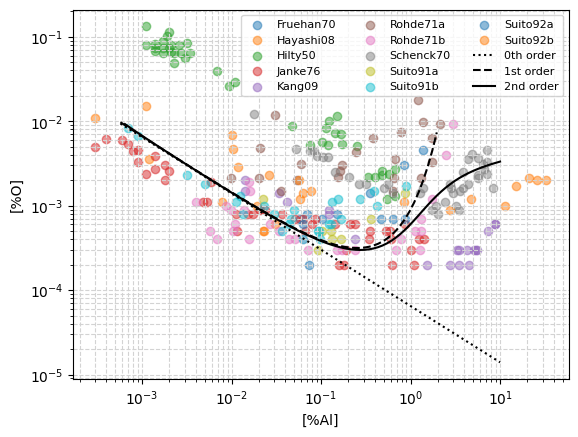

In [9]:
# Plot using pandas and matplotlib:
T = 1873                            # Temperature, K
pcts = np.logspace(-4, 1, 100)      # Al content range, [%Al]
aAl2O3 = 1                          # Al2O3 activity

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot experimental data
refs = df['Source'].unique()
for ref in refs:
    _df = df[(df['Source'] == ref)]
    ax.scatter(_df['pctAl'], _df['pctO'], marker='o', alpha=0.5, label=ref)
        
# Plot model results
orders = [0, 1, 2]
linestyles = [':', '--', '-']
labels = ['0th order', '1st order', '2nd order']
for order, linestyle, label in zip(orders, linestyles, labels):
    pctM, pctO = data_deox(Al_O_eqs, T, pcts, aAl2O3, x0=1e-8, order=order, bound=1e-2)
    ax.plot(pctM, pctO, ls=linestyle, color='k', label=label)
    
# Make the plot pretty
ax.set_xlabel('[%Al]')
ax.set_ylabel('[%O]')

ax.set_xscale('log')
ax.set_yscale('log')

ax.grid(which='both', ls='--', color='lightgray')

ax.legend(loc='upper right', ncols=3, fontsize=8)
plt.show()

### Referencias


[Sigworth, G. K., & Elliott, J. F. (1974)](https://www.researchgate.net/publication/233686082_The_Thermodynamics_of_Liquid_Dilute_Iron_Alloys)  
The thermodynamics of liquid dilute iron alloys.    
Metal science, 8(1), 298-310.     

[Ichise, E. & Moro-Oka, A. (1988)](https://www.jstage.jst.go.jp/article/isijinternational1966/28/3/28_3_153/_pdf)  
Interaction Parameter in Liquid Iron Alloys.    
Transactions of the Iron and Steel Institute of Japan, 28(3), 153-163.

[Zhang, L. et al. (2015)](https://link.springer.com/article/10.1007%2Fs11663-015-0361-7)  
Stability diagram of Mg-Al-O system inclusions in molten steel.    
Metallurgical and Materials Transactions B, 46(4), 1809-1825.   

[Castro-Cedeño, E. I. et al. (2016)](https://link.springer.com/article/10.1007%2Fs11663-016-0640-y)  
Evaluation of steel cleanliness in a steel deoxidized using Al.   
Metallurgical and Materials Transactions B, 47(3), 1613-1625.

[Wang, H. et al (2021)](https://www.sciencedirect.com/science/article/pii/S2238785421001873)  
Three-dimensional stability diagram of Al–Mg–O inclusions in molten steel.    
Journal of Materials Research and Technology, 12, 43-52.